# Test several classification algorithms on Otto product data

This Python3 notebook shows the use of many scikit-learn features. They are applied to the Otto classification challenge hosted by kaggle in 2015 (https://www.kaggle.com/c/otto-group-product-classification-challenge). The train and test data is also available at the given URL. 

A special focus of this notebook lies on xgboost, which plays an important role with respect to computational time and accuracy in many winning solutions of kaggle competitions. Here it also outperforms many other models.

You will find sections to the following topics:
* some visualization techniques (PCA, t-SNE), descriptive statistics with seaborn package
* comparison of classifiers
* hyperparameter tuning / grid search with **xgboost**
* **calibration** to improve predicted class probabilities
* **ensemble learning**: bagging, soft voting, stacking

## Load some packages + general plot settings

In [1]:
import sklearn
print(sklearn.__version__)

0.19.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

## Load Data

In [168]:
path = "data/otto/"
input_file = path + "train.csv"
test_file = path + "test.csv"

train_original = pd.read_csv(input_file, header = 0)
test_original = pd.read_csv(test_file, header = 0)

## Inspect data

In [4]:
train_original.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [107]:
train_original.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Columns: 95 entries, id to target
dtypes: int64(94), object(1)
memory usage: 44.8+ MB


In [6]:
print("Number of instances: ",len(train_original))
print("Type of target classes:",type(train_original["target"][0]))

Number of instances:  61878
Type of target classes: <class 'str'>


In [7]:
class_list = set(train_original["target"])
print("Number of classes: ",len(class_list))

Number of classes:  9


## Some checks on the data
All transformation are performed on copies of the datasets.

**copy data sets**

In [8]:
train = train_original.copy()
test = test_original.copy()

**remove non-number parts of class labels and parse to numeric**

In [9]:
train['target'] = train['target'].str.replace('Class_', '')
train['target'] = pd.to_numeric(train['target'], errors='coerce')

**check for missing values**

In [10]:
print("Number of missing values in training set:", sum(train.isnull().sum()))
print("Number of missing values in test set: ",sum(test.isnull().sum()))

Number of missing values in training set: 0
Number of missing values in test set:  0


**check if any product has no features**

In [11]:
print("Number of products without any feature (train set): ",sum(train.drop(['id','target'],axis=1).sum(axis=1) == 0))
print("Number of products without any feature (test set): ",sum(test.drop(['id'],axis=1).sum(axis=1) == 0))

Number of products without any feature (train set):  0
Number of products without any feature (test set):  1


## Separate data and labels

In [12]:
labels = train["target"].copy()
train = train.drop(['id','target'],axis=1)
test = test.drop('id',axis=1)

**Bar chart of the features**

sum values for all features, sort, and visualize

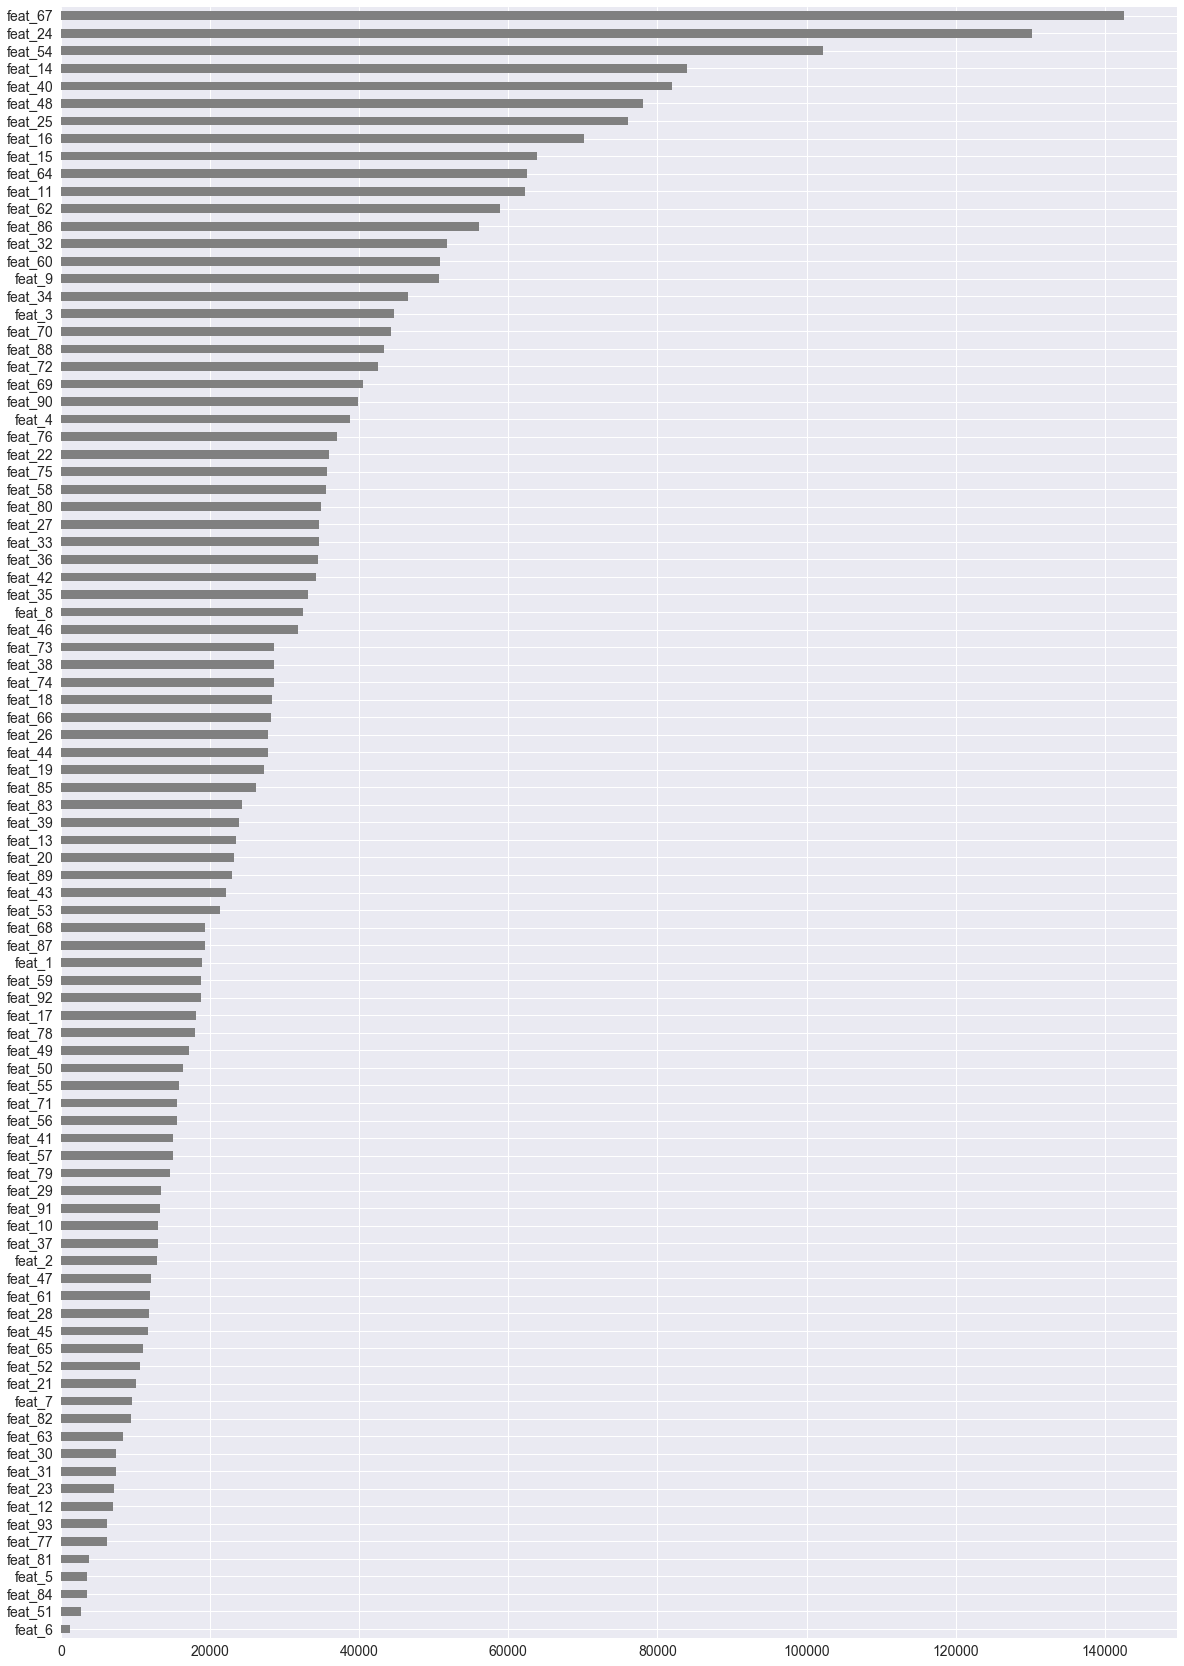

In [167]:
trainSum = train.sum().sort_values(ascending=True)
trainSum.plot(kind='barh',figsize=(20,30),color="Gray")

## Add features, transformation & scaling
Test to add sum of non-zero features and sum of features. Test to scale data. These tests did not bring any improvement, except a very little improvement for the neural network classifier. So, it's not used.

In [14]:
#train = pd.concat([train,train.sum(axis=1),train.astype(bool).sum(axis=1)], axis=1)
#test = pd.concat([test,test.sum(axis=1),test.astype(bool).sum(axis=1)], axis=1)

In [15]:
#train.head()

In [16]:
#train = train.apply(lambda x: np.log(x + 1))
#test = test.apply(lambda x:np.log(x+1))

In [17]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#train = pd.DataFrame(scaler.fit_transform(train),index=train.index, columns=train.columns)
#test = pd.DataFrame(scaler.fit_transform(test),index=test.index, columns=test.columns)

In [18]:
#train.head()

In [19]:
#test.head()

## Separate 20% of training set for validation

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_without_cv = train.copy()
train, validation,labelsTrain,labelsValidation = train_test_split(train,labels,test_size=0.2,random_state=42)

**Histogramm of the classes**

The classes are far away from uniform distribution. The ratio of train and validation set is the same for each label.

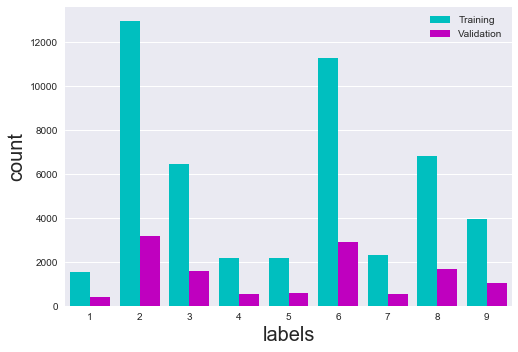

In [22]:
import seaborn as sb
allLabels = np.concatenate((labelsTrain,labelsValidation))
cat1 = np.repeat('training',len(labelsTrain))
cat2 = np.repeat('validation',len(labelsValidation))
cat = np.concatenate((cat1,cat2))
hist_df = pd.DataFrame(({'labels':allLabels, 'datatype':cat}))
p = sb.countplot(data=hist_df,x='labels',hue='datatype',saturation=1,palette=['c', 'm'])
leg = p.get_legend()
leg.set_title("")
labs = leg.texts
labs[0].set_text("Training")
labs[1].set_text("Validation")
plt.xlabel('labels', fontsize=20)
plt.ylabel('count', fontsize=20)

**Visualize data projected on 2 dimensions using PCA**

In [23]:
from sklearn.decomposition import PCA
train_PCA = PCA(n_components=2).fit_transform(train)

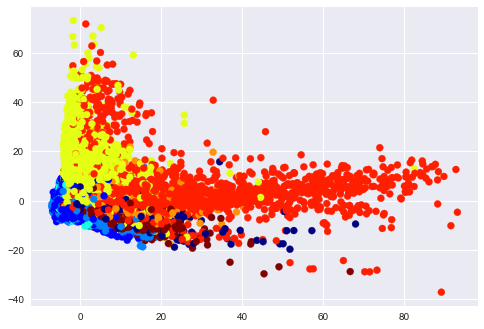

In [24]:
plt.scatter(train_PCA[:,0],train_PCA[:,1],c=labelsTrain,cmap=plt.cm.jet)

**Visualize data projected on 2 dimensions using TSNE**

In [104]:
from sklearn.manifold import TSNE
train_tsne = TSNE(n_components=2).fit_transform(train)
tsne_df = pd.DataFrame({'tsne1':train_tsne[:,0],
                        'tsne2':train_tsne[:,1],
                        'labels':labelsTrain})

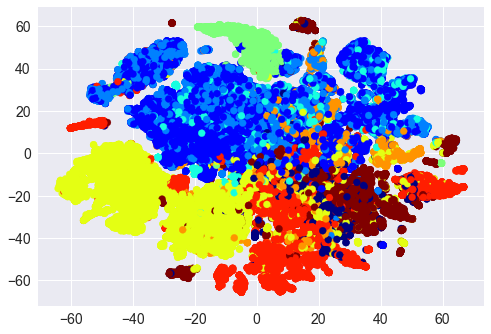

In [106]:
plt.scatter(train_tsne[:,0],train_tsne[:,1],c=labelsTrain,cmap=plt.cm.jet)

## First classification

In [25]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, tol = 1e-3, max_iter = 50000,loss="log")
sgd_clf.fit(train,labelsTrain)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [26]:
some_data = train.iloc[:10]
some_labels = labelsTrain.iloc[:10]
sgd_clf.predict(some_data)

array([4, 2, 8, 3, 8, 2, 8, 2, 2, 2])

In [27]:
print(list(some_labels))

[2, 3, 1, 2, 8, 2, 8, 2, 3, 2]


**Define function for evaluation and test it on the sgd classifier**

In [108]:
from sklearn.metrics import f1_score, log_loss
def evaluate(labelsTrue,predictions1,predictions2):
    if len(predictions1)>0:
        f1 = f1_score(labelsTrue,predictions1,average="weighted")
        print("F1 score: ",f1)
    if len(predictions2)>0:
        logloss = log_loss(labelsTrue,predictions2, eps=1e-15, normalize=True, sample_weight=None, labels=None)
        print("Log loss for predicted probabilities:",logloss)

In [109]:
predictions1_sgd = sgd_clf.predict(validation)
predictions2_sgd = sgd_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_sgd,predictions2_sgd)

F1 score:  0.726589428411
Log loss for predicted probabilities: 0.932644531719


/Users/bettina/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


## Compare several classifiers

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

**Nearest Neighbors classification**

In [33]:
knn_clf = KNeighborsClassifier()

In [34]:
knn_clf.fit(train,labelsTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [35]:
predictions1_knn = knn_clf.predict(validation)
predictions2_knn = knn_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_knn,predictions2_knn)

F1 score:  0.773956219143
Log loss for predicted probabilities: 2.30867760766


**Linear SVM**

In [36]:
svc_clf = SVC(kernel="linear", probability=True)

In [37]:
svc_clf.fit(train,labelsTrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
predictions1_svc = svc_clf.predict(validation)
predictions2_svc = svc_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_svc,predictions2_svc)

F1 score:  0.74222235161
Log loss for predicted probabilities: 0.629565432372


**Random Forest**

In [39]:
forest_clf = RandomForestClassifier(n_estimators=50,n_jobs=-1)

In [40]:
forest_clf.fit(train,labelsTrain)
predictions1_forest = forest_clf.predict(validation)
predictions2_forest = forest_clf.predict_proba(validation)

In [41]:
evaluate(labelsValidation,predictions1_forest,predictions2_forest)

F1 score:  0.796937197215
Log loss for predicted probabilities: 0.674761401567


**Extra Trees**

In [42]:
trees_clf = ExtraTreesClassifier(n_estimators=50,n_jobs=-1)

In [43]:
trees_clf.fit(train,labelsTrain)
predictions1_trees = trees_clf.predict(validation)
predictions2_trees = trees_clf.predict_proba(validation)

In [44]:
evaluate(labelsValidation,predictions1_trees,predictions2_trees)

F1 score:  0.801828331218
Log loss for predicted probabilities: 0.683383987945


**Neural Net**

In [45]:
mlp_clf = MLPClassifier()
mlp_clf.fit(train,labelsTrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [46]:
predictions1_mlp = mlp_clf.predict(validation)
predictions2_mlp = mlp_clf.predict_proba(validation)

In [47]:
evaluate(labelsValidation,predictions1_mlp,predictions2_mlp)

F1 score:  0.788484789055
Log loss for predicted probabilities: 0.678855485507


**Ada Boost**

In [48]:
ada_clf = AdaBoostClassifier()

In [49]:
ada_clf.fit(train,labelsTrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [50]:
predictions1_ada = ada_clf.predict(validation)
predictions2_ada = ada_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_ada,predictions2_ada)

F1 score:  0.674407292188
Log loss for predicted probabilities: 2.02619365313


**Naive Bayes**

In [51]:
bayes_clf = GaussianNB()
bayes_clf.fit(train,labelsTrain)

GaussianNB(priors=None)

In [52]:
predictions1_bayes = bayes_clf.predict(validation)
predictions2_bayes = bayes_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_bayes,predictions2_bayes)

F1 score:  0.628630223027
Log loss for predicted probabilities: 7.25188009242


**XGBoost**

In [53]:
xgb_clf = XGBClassifier(num_class = 9,objective="multi:softprob",eval_metric="mlogloss")
xgb_clf.fit(train,labelsTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [54]:
predictions1_xgb = xgb_clf.predict(validation)
predictions2_xgb = xgb_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_xgb,predictions2_xgb)

F1 score:  0.757824746338
Log loss for predicted probabilities: 0.648326800485


## Grid search: hyperparameter tuning for xgboost

The final parameter combination was obtained by a variety of different combinations in the comments below (full grid search suffers from curse of dimensionality and was not run). The combination receives a good result, but does not claim to be the best existing one. With more computational power a more intense search would be possible.

In [55]:
from sklearn.model_selection import GridSearchCV
xgb_gs_clf = XGBClassifier(num_class = 9,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           base_score=0.5,
                           max_delta_step=0,
                           seed=42)                         
                        
param_grid = {"max_depth": [10], #[3,10,15,25,50,100],
              "n_estimators": [300] , #[100,200,300,400,500] 
              "gamma": [0.03], #[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07],
              "learning_rate": [0.08], #[0.01,0.05,0.08,0.1,0.2],
              "min_child_weight": [5], #[1,2,3,4,5,6]
              "colsample_bytree": [0.8], #[0.8,0.9,1]
              "subsample": [0.85]} #[0.8,0.85,0.9,1]

grid_search = GridSearchCV(xgb_gs_clf, 
                           param_grid=param_grid,
                           cv = 2,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(train,labelsTrain)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] colsample_bytree=0.8, gamma=0.03, learning_rate=0.08, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.85 
[CV] colsample_bytree=0.8, gamma=0.03, learning_rate=0.08, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.85 
[CV]  colsample_bytree=0.8, gamma=0.03, learning_rate=0.08, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.85, total= 9.4min
[CV]  colsample_bytree=0.8, gamma=0.03, learning_rate=0.08, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.85, total= 9.5min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.8min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10], 'n_estimators': [300], 'gamma': [0.03], 'learning_rate': [0.08], 'min_child_weight': [5], 'colsample_bytree': [0.8], 'subsample': [0.85]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=2)

In [56]:
print(grid_search.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0.03, 'learning_rate': 0.08, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.85}


In [57]:
predictions1_gs = grid_search.predict(validation)
predictions2_gs = grid_search.predict_proba(validation)

In [58]:
evaluate(labelsValidation,predictions1_gs,predictions2_gs)

F1 score:  0.820975601986
Log loss for predicted probabilities: 0.451354315302


**Use best parameter set from now on**

In [60]:
xgb_clf = grid_search.best_estimator_
predictions1_xgb = predictions1_gs
predictions2_xgb = predictions2_gs

**Plot confusion matrix for best parameter set**

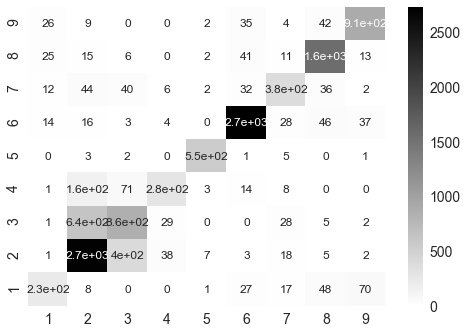

In [165]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labelsValidation,predictions1_xgb)
#plt.matshow(conf_matrix,cmap=plt.cm.gray)

df_cm = pd.DataFrame(conf_matrix, range(1,10),range(1,10))
sb.set(font_scale=1.4)
ax = sb.heatmap(df_cm, annot=True,annot_kws={"size": 12},cmap="binary")
ax.invert_yaxis()

**Plot confusion matrix with relative values and diagonal set to 0**

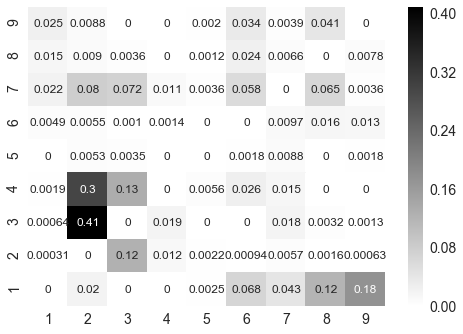

In [164]:
row_sums = conf_matrix.sum(axis=1,keepdims=True)
norm_conf_matrix = conf_matrix/row_sums
np.fill_diagonal(norm_conf_matrix,0)
df_cm = pd.DataFrame(norm_conf_matrix, range(1,10),range(1,10))
sb.set(font_scale=1.4)
ax = sb.heatmap(df_cm, annot=True,annot_kws={"size": 12},cmap="binary")
ax.invert_yaxis()

**Feature importances**

features = train.columns
importances = xgb_clf.feature_importances_
importances = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(importances)

plt.figure(figsize=(20,30))
plt.barh(range(len(sorted_idx)),importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Relative importance', fontsize=20)
plt.ylabel('features', fontsize=20)
plt.title('Feature importance', fontsize=20)
plt.show()

**Correlations between predicted classes**

In [156]:
predictions = pd.DataFrame( {'RandomForest': predictions1_forest,
                                  'xgboost': predictions1_xgb,
                                  'NearestNeighbours': predictions1_knn,
                                  'NeuralNetworrk': predictions1_mlp,
                                  'SupportVectorMachine': predictions1_svc,
                                  'ExtraTrees': predictions1_trees,
                                  'AdaBoost': predictions1_ada,
                                  'NaiveBayes': predictions1_bayes,
                                  'LogisticRegression':predictions1_sgd,
                        
    })
predictions.head()

,AdaBoost,ExtraTrees,LogisticRegression,NaiveBayes,NearestNeighbours,NeuralNetworrk,RandomForest,SupportVectorMachine,xgboost
0,2,2,2,4,2,7,2,2,7
1,1,7,7,3,7,7,7,7,7
2,6,6,6,6,6,6,6,6,6
3,4,6,4,9,6,6,6,6,6
4,6,6,6,6,6,6,6,6,6


**Correlations between predicted class probabilities**

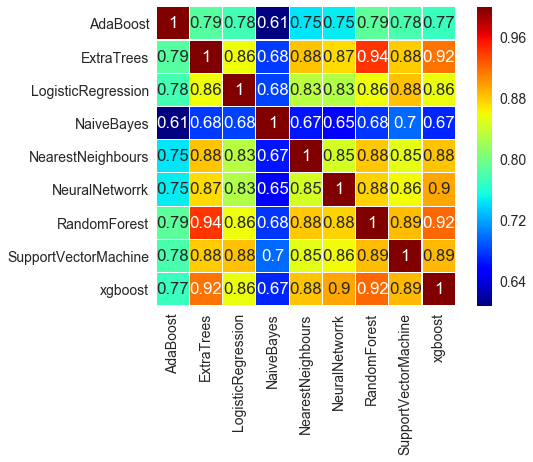

In [157]:
sb.heatmap(predictions.corr(),
           linewidths=0.1,
           vmax=1.0,
           square=True,
           cmap='jet',
           linecolor='white',
           annot=True)

In [158]:
predictions_prob = pd.DataFrame( {'RandomForest': predictions2_forest.reshape(-1,1).ravel(),
                                  'xgboost': predictions2_xgb.reshape(-1,1).ravel(),
                                  'NearestNeighbours': predictions2_knn.reshape(-1,1).ravel(),
                                  'NeuralNetworrk': predictions2_mlp.reshape(-1,1).ravel(),
                                  'SupportVectorMachine': predictions2_svc.reshape(-1,1).ravel(),
                                  'ExtraTrees': predictions2_trees.reshape(-1,1).ravel(),
                                  'AdaBoost': predictions2_ada.reshape(-1,1).ravel(),
                                  'NaiveBayes': predictions2_bayes.reshape(-1,1).ravel(),
                                  'LogisticRegression':predictions2_sgd.reshape(-1,1).ravel(),
    })
predictions_prob.head()

,AdaBoost,ExtraTrees,LogisticRegression,NaiveBayes,NearestNeighbours,NeuralNetworrk,RandomForest,SupportVectorMachine,xgboost
0,0.108804,0.10,0.034200,1.179364e-26,0.0,0.001640,0.06,0.099872,0.006355
1,0.115345,0.24,0.369294,9.291184e-05,0.4,0.014586,0.30,0.208105,0.185336
2,0.109224,0.18,0.132963,5.275681e-09,0.0,0.008437,0.10,0.136510,0.026465
3,0.112771,0.10,0.061633,9.891773e-01,0.2,0.062664,0.18,0.112896,0.149922
4,0.105996,0.14,0.189083,1.072974e-02,0.2,0.004372,0.10,0.142247,0.165746


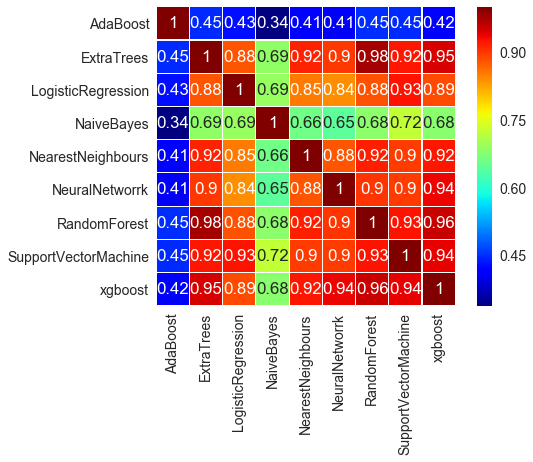

In [159]:
sb.heatmap(predictions_prob.corr(),
           linewidths=0.1,
           vmax=1.0,
           square=True,
           cmap='jet',
           linecolor='white',
           annot=True)

## Ensemble learning: Bagging, Voting, Stacking

**Bagging of xgboost**

This did not bring improvement, with calibration neither. It probably does not make so much sense to apply bagging/boosting to a learner based on boosting.

In [64]:
from sklearn.ensemble import BaggingClassifier

In [66]:
bagging_clf = BaggingClassifier(xgb_clf,n_jobs=-1,verbose=2)
bagging_clf.fit(train,labelsTrain)

Building estimator 1 of 3 for this parallel run (total 10)...
Building estimator 1 of 3 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 2 of 3 for this parallel run (total 10)...
Building estimator 2 of 2 for this parallel run (total 10)...
Building estimator 2 of 3 for this parallel run (total 10)...
Building estimator 2 of 2 for this parallel run (total 10)...
Building estimator 3 of 3 for this parallel run (total 10)...
Building estimator 3 of 3 for this parallel run (total 10)...


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 81.7min finished


BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mlogloss', gamma=0.03,
       learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.85),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=2, warm_start=False)

In [67]:
predictions1_bagging = bagging_clf.predict(validation)
predictions2_bagging = bagging_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_bagging,predictions2_bagging)

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   43.2s finished


F1 score:  0.821850638172
Log loss for predicted probabilities: 0.452311152007


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   46.1s finished


**Voting Classifier**

The soft voting result is worse than the single run of xgboost, but with calibration the loss is improved a bit (see the next section). To include more classifiers into the soft voting classifier did not bring any improvement - at least not with the used hyperparameters. More tests would be necessary.

In [68]:
from sklearn.ensemble import VotingClassifier

In [98]:
voting_clf = VotingClassifier(
    estimators=[('xgb',xgb_clf),('mlp',mlp_clf),('rf',forest_clf)],
    voting = 'soft',
    n_jobs=-1)
voting_clf.fit(train,labelsTrain)

VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mlogloss', gamma=0.03,
       learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=Non..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [99]:
predictions1_voting = voting_clf.predict(validation)
predictions2_voting = voting_clf.predict_proba(validation)
evaluate(labelsValidation,predictions1_voting,predictions2_voting)

F1 score:  0.818759874742
Log loss for predicted probabilities: 0.474332420544


**Stacking models**

Inspired by 
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

The stacking of 5 base models and xgboost as the second stage model brings a little bit of improvement - with calibration even more (see the next section). All predicted class probabilities are used as intermediate features.

In [71]:
base1_clf = mlp_clf
base2_clf = forest_clf
base3_clf = knn_clf
base4_clf = ada_clf
base5_clf = svc_clf
final_clf = xgb_clf

In [72]:
SEED = 42
NFOLDS = 5
NCLASSES = len(class_list)
from sklearn.model_selection import KFold
kf = KFold(n_splits= NFOLDS, shuffle=True, random_state=SEED)

In [73]:
def get_oof(clf, x_train, y_train, x_test):
    ntest = x_test.shape[0]
    oof_train = np.zeros((x_train.shape[0],NCLASSES))
    oof_test = np.zeros((ntest,NCLASSES))
    oof_test_temp = np.empty((NFOLDS, ntest))
   
    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
  
        # for each fold train on the rest and predict on the hold out set
        clf.fit(x_tr, y_tr)

        pred_te = clf.predict_proba(x_te)
        oof_train[test_index,:] = pred_te
        
        pred_test = clf.predict_proba(x_test)
        oof_test += pred_test

    return oof_train, oof_test/NFOLDS

In [74]:
x_train = train.values
x_test = validation.values
y_train = labelsTrain.ravel()

In [75]:
base1_oof_train, base1_oof_test = get_oof(base1_clf, x_train, y_train, x_test)
base2_oof_train, base2_oof_test = get_oof(base2_clf, x_train, y_train, x_test)
base3_oof_train, base3_oof_test = get_oof(base3_clf, x_train, y_train, x_test)
base4_oof_train, base4_oof_test = get_oof(base4_clf, x_train, y_train, x_test) 
base5_oof_train, base5_oof_test = get_oof(base5_clf, x_train, y_train, x_test) 

In [81]:
x_train = np.concatenate((base1_oof_train, 
                          base2_oof_train,
                          base3_oof_train,
                          base4_oof_train,
                          base5_oof_train), axis=1)
x_test = np.concatenate((base1_oof_test,
                         base2_oof_test,
                         base3_oof_test,
                         base4_oof_test,
                         base5_oof_test), axis=1)

In [82]:
final_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mlogloss', gamma=0.03,
       learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.85)

In [83]:
predictions1_stacked = final_clf.predict(x_test)
predictions2_stacked = final_clf.predict_proba(x_test)
evaluate(labelsValidation,predictions1_stacked,predictions2_stacked)

F1 score:  0.825662856305
Log loss for predicted probabilities: 0.451834513447


## Calibration

Calibration improves the underlying models significantly for all cases below. For the neural network it did not bring any improvement, but it seems to be effective for models inheritently based on boosting methods.

**Calibrated xgboost Classifier**

In [84]:
from sklearn.calibration import CalibratedClassifierCV

In [85]:
calibrated_xgb_clf = CalibratedClassifierCV(xgb_clf, method='isotonic', cv=5)
calibrated_xgb_clf.fit(train, labelsTrain)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mlogloss', gamma=0.03,
       learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.85),
            cv=5, method='isotonic')

In [86]:
predictions2_cal = calibrated_xgb_clf.predict_proba(validation)
evaluate(labelsValidation,[],predictions2_cal)
# 0.44320 on test set (trained on full training set)

Log loss for predicted probabilities: 0.449209058657


**Calibrated random forest**

In [87]:
calibrated_forest_clf = CalibratedClassifierCV(forest_clf, cv=5, method='isotonic')

In [88]:
calibrated_forest_clf.fit(train, labelsTrain)
predictions2_forest_cal = calibrated_forest_clf.predict_proba(validation)

In [89]:
evaluate(labelsValidation,[],predictions2_forest_cal)

Log loss for predicted probabilities: 0.492046938039


**Calibrated Voting Classifier**

In [100]:
calibrated_voting_clf = CalibratedClassifierCV(voting_clf, method='isotonic', cv=5)
calibrated_voting_clf.fit(train, labelsTrain)

CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mlogloss', gamma=0.03,
       learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=3...       warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None),
            cv=5, method='isotonic')

In [101]:
predictions2_voting_cal = calibrated_voting_clf.predict_proba(validation)
evaluate(labelsValidation,[],predictions2_voting_cal)
# 0.44098 on test set (trained on full training set)

Log loss for predicted probabilities: 0.447722215871


**Calibrated Stacked Classifier**

In [92]:
calibrated_stacked_clf = CalibratedClassifierCV(final_clf, method='isotonic', cv=5)
calibrated_stacked_clf.fit(x_train,y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mlogloss', gamma=0.03,
       learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.85),
            cv=5, method='isotonic')

In [93]:
predictions2_stacked_cal = calibrated_stacked_clf.predict_proba(x_test)
evaluate(labelsValidation,[],predictions2_stacked_cal)
# 0.42872 on test set (trained on full training set)

Log loss for predicted probabilities: 0.442302518558


## Build submission file

In [163]:
def saveSolution(clf, x_train, y_train, x_test, filename):
    clf.fit(x_train,y_train)
    predictions = clf.predict_proba(x_test)
    col_names = list(class_list)
    col_names.sort()
    df_submission = pd.DataFrame(predictions,columns=col_names)
    df_submission = pd.concat([test_original['id'], df_submission], axis=1)
    submission_file = path + filename
    df_submission.to_csv(submission_file, index=False)

In [ ]:
saveSolution(calibrated_xgb_clf,train_without_cv,labels,test,"predictions_xgb_cal.csv")
saveSolution(calibrated_voting_clf,train_without_cv,labels,test,"predictions_voting_cal.csv")

In [ ]:
x_train = train_without_cv.values
x_test = test.values
y_train = labels.ravel()
base1_oof_train, base1_oof_test = get_oof(base1_clf, x_train, y_train, x_test)
base2_oof_train, base2_oof_test = get_oof(base2_clf, x_train, y_train, x_test)
base3_oof_train, base3_oof_test = get_oof(base3_clf, x_train, y_train, x_test)
base4_oof_train, base4_oof_test = get_oof(base4_clf, x_train, y_train, x_test) 
base5_oof_train, base5_oof_test = get_oof(base5_clf, x_train, y_train, x_test)
x_train = np.concatenate((base1_oof_train, 
                          base2_oof_train,
                          base3_oof_train,
                          base4_oof_train,
                          base5_oof_train), axis=1)
x_test = np.concatenate((base1_oof_test,
                         base2_oof_test,
                         base3_oof_test,
                         base4_oof_test,
                         base5_oof_test), axis=1)
saveSolution(calibrated_stacked_clf,x_train,y_train,x_test,"predictions_stacked_cal.csv")